In [7]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()
using FerriteViz
using Ferrite, SparseArrays, LinearAlgebra
using FerriteGmsh, LaTeXStrings, Plots
include("reactive_stats_struct.jl")
include("commonitors.jl")

meshgrid(x, y) = (repeat(x, outer=length(y)), repeat(y, inner=length(x)))
left_bott = [-1.25,-1.25]
left_upper = [-1.25,5.0] #-1.25, 5
right_bott = [5.0,-1.25] #5, -1.25
function tri_grid(left_bott, left_upper, right_bott)
    gmsh.initialize()
    dim = Int64(gmsh.model.getDimension())
    a = -1
    b = left_upper[2] - a*left_bott[1]
    gmsh.model.occ.addPoint(left_bott[1], left_bott[2], 0, 0, 1)
    gmsh.model.occ.addPoint(left_upper[1], left_upper[2], 0, 0, 2)
    gmsh.model.occ.addPoint(right_bott[1], right_bott[2], 0, 0, 3)

    gmsh.model.occ.addLine(1, 2, 4)
    gmsh.model.occ.addLine(2, 3, 5)
    gmsh.model.occ.addLine(3, 1, 6)

    gmsh.model.occ.addCurveLoop([4, 5, 6], 1)

    tri = gmsh.model.occ.addPlaneSurface([1], 1)

    gmsh.model.occ.synchronize()
    gmsh.model.addPhysicalGroup(2, [tri], 2)

    #meshSize = 0.05
    gmsh.option.setNumber("Mesh.CharacteristicLengthMin",0.035)
    gmsh.option.setNumber("Mesh.CharacteristicLengthMax",0.035)
    gdim = 2
    gmsh.model.mesh.generate(gdim)
    gmsh.model.mesh.reverse()
    dim = Int64(gmsh.model.getDimension())

    facedim = dim - 1 

    nodes = tonodes()
    elements, gmsh_elementidx = toelements(dim)
    cellsets = tocellsets(dim, gmsh_elementidx)

    # "Domain" is the name of a PhysicalGroup and saves all cells that define the computational domain
    domaincellset = cellsets["2"]
    elements = elements[collect(domaincellset)]


    boundarydict = toboundary(facedim)
    facesets = tofacesets(boundarydict, elements)
    gmsh.finalize()

    grid = Grid(elements, nodes, facesets=facesets, cellsets=cellsets)

    addfaceset!(grid, "top", x -> x[2] ≈ a*x[1]+b);
    addfaceset!(grid, "left", x -> x[1] ≈ left_upper[1]);
    addfaceset!(grid, "right", x -> x[1] ≈ 20);
    addfaceset!(grid, "bottom", x -> x[2] ≈ right_bott[2]);
    return grid
end

function create_tri_mesh_comm(A_center, A_radius, B_center, B_radius, left_bott, left_upper, right_bott)
    gmsh.initialize()
    dim = Int64(gmsh.model.getDimension())
    a = -1
    b = left_upper[2] - a*left_bott[1]
    gmsh.model.occ.addPoint(left_bott[1], left_bott[2], 0, 0, 1)
    gmsh.model.occ.addPoint(left_upper[1], left_upper[2], 0, 0, 2)
    gmsh.model.occ.addPoint(right_bott[1], right_bott[2], 0, 0, 3)

    gmsh.model.occ.addLine(1, 2, 4)
    gmsh.model.occ.addLine(2, 3, 5)
    gmsh.model.occ.addLine(3, 1, 6)

    gmsh.model.occ.addCurveLoop([4, 5, 6], 1)

    tri = gmsh.model.occ.addPlaneSurface([1], 1)

    gmsh.model.occ.synchronize()
    gmsh.model.addPhysicalGroup(2, [tri], 2)
    #######

    hole1 = gmsh.model.occ.addDisk(A_center[1], A_center[2], 0, A_radius, A_radius)
    hole2 = gmsh.model.occ.addDisk(B_center[1], B_center[2], 0, B_radius, B_radius)
    membrane1 = gmsh.model.occ.cut([(2, 1)], [(2, hole1), (2,hole2)])
    gmsh.model.occ.synchronize()

    volumes = gmsh.model.getEntities()
    gdim = 2
    gmsh.model.addPhysicalGroup(volumes[1][1], [volumes[1][2]], 11)

    boundary = gmsh.model.getBoundary(membrane1[1])
    boundary_ids = [b[1] for b in boundary]
    gmsh.model.addPhysicalGroup(2, boundary_ids)

    meshSize = 0.035
    gmsh.option.setNumber("Mesh.CharacteristicLengthMin",meshSize)
    gmsh.option.setNumber("Mesh.CharacteristicLengthMax",meshSize)
    gmsh.model.mesh.generate(gdim)
    gmsh.model.mesh.reverse()
    dim = Int64(gmsh.model.getDimension())
    facedim = dim - 1 

    nodes = tonodes()
    elements, gmsh_elementidx = toelements(dim)
    cellsets = tocellsets(dim, gmsh_elementidx)

    # "Domain" is the name of a PhysicalGroup and saves all cells that define the computational domain
    domaincellset = cellsets["12"]
    elements = elements[collect(domaincellset)]


    boundarydict = toboundary(facedim)
    facesets = tofacesets(boundarydict, elements)
    gmsh.finalize()
    grid = Grid(elements, nodes, facesets=facesets, cellsets=cellsets)

    addfaceset!(grid, "top", x -> x[2] ≈ a*x[1]+b);
    addfaceset!(grid, "left", x -> x[1] ≈ left_upper[1]);
    addfaceset!(grid, "right", x -> x[1] ≈ 20);
    addfaceset!(grid, "bottom", x -> x[2] ≈ right_bott[2]);
    addfaceset!(grid, "A", x -> (x[1]-A_center[1])^2+(x[2]-A_center[2])^2 ≈ A_radius^2);
    addfaceset!(grid, "B", x -> (x[1]-B_center[1])^2+(x[2]-B_center[2])^2 ≈ B_radius^2);
    return grid        
end

function trans_stat(result_loc::Vector{Vector{Float64}}, base_info::grid_info, react_stat::reactive_stat, length::Int64)
    points = [Vec((x, y)) for y in range(result_loc[2][1], result_loc[2][2], length=length) for x in range(result_loc[1][1],result_loc[1][2],length = length)];
    ph_stat = PointEvalHandler(base_info.grid_stat, points, warn = false);
    ph_comm = PointEvalHandler(base_info.grid_comm, points, warn = false);

    u_points_stat = Ferrite.get_point_values(ph_stat, base_info.dh_stat, react_stat.u_stat, :u);
    u_points_forward = Ferrite.get_point_values(ph_comm, base_info.dh_comm, react_stat.u_forward, :u);
    u_points_back = Ferrite.get_point_values(ph_comm, base_info.dh_comm, react_stat.u_backward, :u);

    distribution_points = get_point_values(ph_comm, L2Projector(base_info.ip, base_info.grid_comm), react_stat.reactive_density);
    distribution_points = permutedims(hcat(distribution_points...));

    current_points = get_point_values(ph_comm, L2Projector(base_info.ip, base_info.grid_comm), react_stat.reactive_current);
    current_points = permutedims(hcat(current_points...));

    return u_points_forward, u_points_back, u_points_stat, distribution_points, current_points
end

  Activating project at `~/Desktop/tpt_code`


trans_stat (generic function with 1 method)

In [2]:
a = 0.65; b = 1.2; k = 0.8; s = 0.6; n = 4; g0 = 0.2 
grid_loc = [left_bott,left_upper,right_bott];
range_loc = [[-0.5,1.0],[0.35,3.0], [1.0, -0.5],[3.5,0.25]];
stat_loc = [[-0.5,4.5],[-0.5,4.5]];
curr_loc = [[0.0,3.0],[0.0,2.5]];
sigma = 0.45

0.45

In [4]:
#for additive noise 
sigma = 0.45
g1(x) = g0+a*x[1]^n/(s^n+x[1]^n)+(b*s^n)/(s^n+x[2]^n)-k*x[1]; g2(x) = g0+a*x[2]^n/(s^n+x[2]^n)+(b*s^n)/(s^n+x[1]^n)-k*x[2];
g = [g1, g2]
D12(x) = 0;D21(x) = 0;
D11(x) = sigma^2; D22(x) = sigma^2
D = [D11 D12;D21 D22];

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 4 (Line)
Info    : [ 40%] Meshing curve 5 (Line)
Info    : [ 70%] Meshing curve 6 (Line)
Info    : Done meshing 1D (Wall 0.000206042s, CPU 0.000194s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.317647s, CPU 0.314846s)
Info    : 18856 nodes 37713 elements


┌ Warning: no entities added to the set with name: right
└ @ Ferrite ~/.julia/packages/Ferrite/5Ozov/src/Grid/grid.jl:635


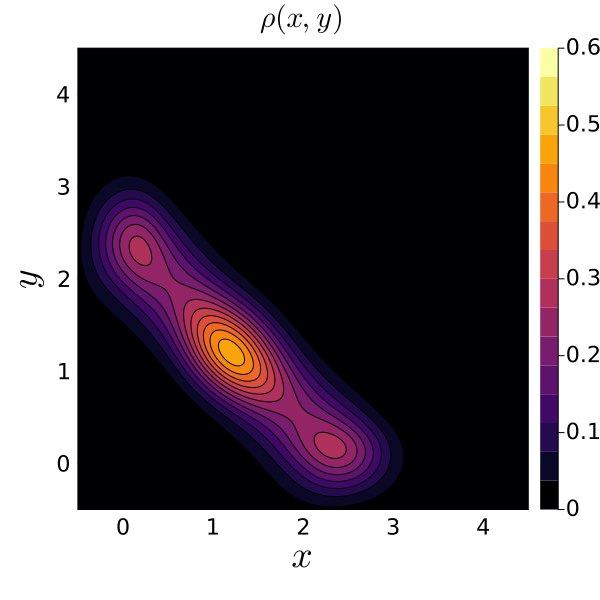

In [5]:
base_info2 = grid_info();
base_info2.grid_stat = tri_grid(left_bott, left_upper, right_bott)
base_info2.dh_stat = create_dofhandler(base_info2.grid_stat);
#implement the information of boundary conditions, and diffusion matrix 
implement_grid(base_info2, D, g)
#initialize the reactive statistics 
react_stat2 = reactive_stat();

compute_stat_dist(base_info2, react_stat2)

points = [Vec((x, y)) for y in range(stat_loc[2][1], stat_loc[2][2], length=200) for x in range(stat_loc[1][1],stat_loc[1][2],length = 200)];
ph_stat = PointEvalHandler(base_info2.grid_stat, points, warn = false);

u_points_stat = Ferrite.get_point_values(ph_stat, base_info2.dh_stat, react_stat2.u_stat, :u);
x = range(-0.5, 4.5, length=200);y = range(-0.5, 4.5, length=200);
replace!(u_points_stat, NaN=>0)
contourf(x,y,u_points_stat, title = L"\rho(x,y)", xlab = L"x", ylab = L"y", clim = (0, 0.6),size = (600,600),ytickfont=font(15), xtickfont=font(15), guidefont=font(25), legenfont = font(14), framestyle = :box, titlefont = font(20))


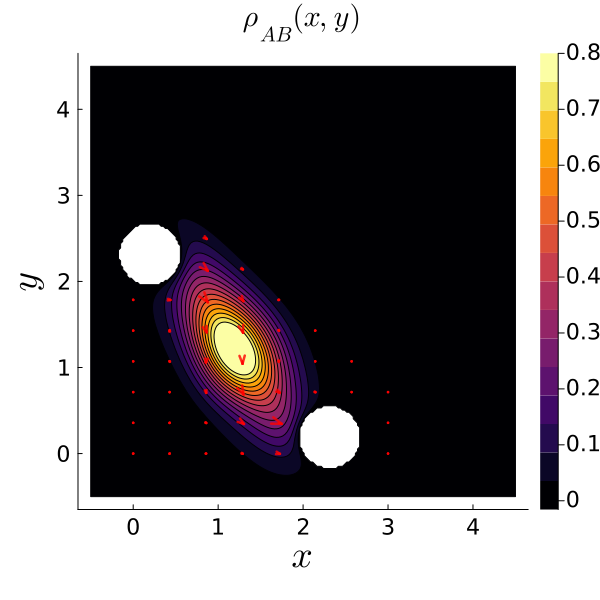

In [8]:
implement_grid_tri(range_loc, grid_loc, base_info2, react_stat2)
obtain_commonitor(base_info2, react_stat2);
_, _, u_points_stat2, distribution_points2, current_points2 = export_result(base_info2, react_stat2, stat_loc, curr_loc, 8)

x = range(0, 3.0, length=8); y = range(0, 2.5, length = 8);
x_mesh, y_mesh = meshgrid(x, y)
x = range(-0.5, 4.5, length=200); y = range(-0.5, 4.5, length=200);

#setting probability outside the bounary of mesh to 0
idx = zeros(40000)
for i in 1:40000
    if points[i][1] + points[i][2] >= 3.75
        idx[i] = 1
    end
end
idx = Int.(idx)
idxx = findall(x-> x==1.0, idx)
distribution_points2[idxx] .= 0

p1 = contourf(x,y,distribution_points2[:,1], title = L"\rho_{AB}(x,y)",xlab = L"x", ylab = L"y", clim = (-0.0157, 0.8), size = (600,600),ytickfont=font(15), xtickfont=font(15), guidefont=font(25), legenfont = font(14), titlefont = font(20), grid = false)
arrow0!.(x_mesh, y_mesh, current_points2[:,1].*1.5, current_points2[:,2].*1.5; as=3.5, lw=2.5,lc=:red, la=0.8);
Plots.current()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 4 (Line)
Info    : [ 40%] Meshing curve 5 (Line)
Info    : [ 70%] Meshing curve 6 (Line)
Info    : Done meshing 1D (Wall 0.000230542s, CPU 0.000226s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.380106s, CPU 0.360957s)
Info    : 18856 nodes 37713 elements
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 7 (Ellipse)
Info    : [ 20%] Meshing curve 8 (Ellipse)
Info    : [ 40%] Meshing curve 9 (Line)
Info    : [ 60%] Meshing curve 10 (Line)
Info    : [ 80%] Meshing curve 11 (Line)
Info    : Done meshing 1D (Wall 0.000344292s, CPU 0.00032s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.330616s, CPU 0.309987s)
Info    : 18310 nodes 36627 elements


┌ Warning: no entities added to the set with name: right
└ @ Ferrite ~/.julia/packages/Ferrite/5Ozov/src/Grid/grid.jl:635
┌ Warning: no entities added to the set with name: right
└ @ Ferrite ~/.julia/packages/Ferrite/5Ozov/src/Grid/grid.jl:635


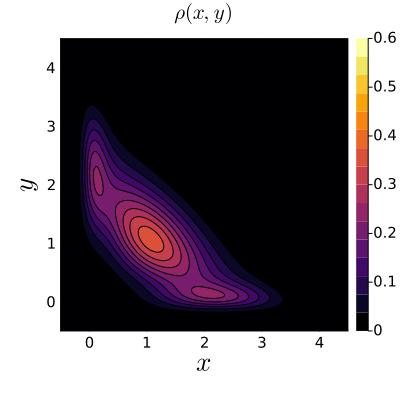

In [9]:
D11(x) = sigma^2*(g0+a*x[1]^n/(s^n+x[1]^n)+(b*s^n)/(s^n+x[2]^n)+k*x[1])
D22(x) = sigma^2*(g0+a*x[2]^n/(s^n+x[2]^n)+(b*s^n)/(s^n+x[1]^n)+k*x[2]);
D = [D11 D12;D21 D22];

base_info2_multi = grid_info();
base_info2_multi.grid_stat = tri_grid(left_bott, left_upper, right_bott)
base_info2_multi.dh_stat = create_dofhandler(base_info2_multi.grid_stat);
implement_grid(base_info2_multi, D, g)
react_stat2_multi = reactive_stat();
compute_stat_dist(base_info2_multi, react_stat2_multi)
implement_grid_tri(range_loc, grid_loc, base_info2_multi, react_stat2_multi)
obtain_commonitor(base_info2_multi, react_stat2_multi);

points = [Vec((x, y)) for y in range(stat_loc[2][1], stat_loc[2][2], length=200) for x in range(stat_loc[1][1],stat_loc[1][2],length = 200)];
ph_stat = PointEvalHandler(base_info2_multi.grid_stat, points, warn = false);
u_points_stat2 = Ferrite.get_point_values(ph_stat, base_info2_multi.dh_stat, react_stat2_multi.u_stat, :u);
x = range(-0.5, 4.5, length=200);y = range(-0.5, 4.5, length=200);
replace!(u_points_stat2, NaN=>0)
contourf(x,y,u_points_stat2, clim = (0, 0.6), title = L"\rho(x,y)", xlab = L"x", ylab = L"y", size = (400,400),ytickfont=font(10), xtickfont=font(10), guidefont=font(18), legenfont = font(18))



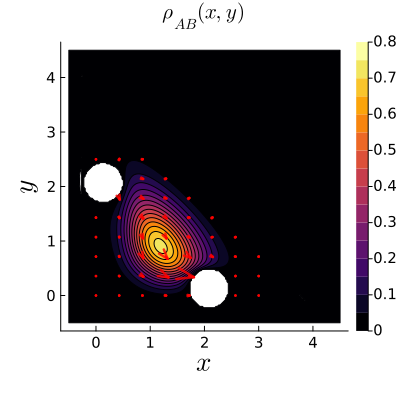

In [10]:
_, _, u_points_stat2_mult, distribution_points2_mult, current_points2_mult = export_result(base_info2_multi, react_stat2_multi, stat_loc, curr_loc, 8)
x = range(0, 3.0, length=8); y = range(0, 2.5, length = 8);
x_mesh, y_mesh = meshgrid(x, y)
x = range(-0.5, 4.5, length=200); y = range(-0.5, 4.5, length=200);

idx = zeros(40000)
for i in 1:40000
    if points[i][1] + points[i][2] >= 3.75
        idx[i] = 1
    end
end
idx = Int.(idx)
idxx = findall(x-> x==1.0, idx)
distribution_points2_mult[idxx] .= 0


p1 = contourf(x,y,distribution_points2_mult[:,1], title = L"\rho_{AB}(x,y)", xlab = L"x", ylab = L"y", size = (400,400), clim = (0, 0.8),ytickfont=font(10), xtickfont=font(10), guidefont=font(18), legenfont = font(18), grid = false)
meshgrid(x, y) = (repeat(x, outer=length(y)), repeat(y, inner=length(x)))
arrow0!.(x_mesh, y_mesh, current_points2_mult[:,1].*1.5, current_points2_mult[:,2].*1.5; as=3.5, lw=2.5,lc=:red, la=0.8);
Plots.current()